# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Homework 3 - Forecasting Bike Sharing Usage



**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">

In [31]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.

Names of people you have worked with goes here:

<hr style="height:2pt">

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Subset Selection, Polynomial Regression </div>
### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. Your task is to prepare a short report summarizing your findings and make recommendations.

The predicted hourly demand could be used for planning the number of bikes that need to be available in the system at any given hour of the day. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore techniques for subset selection to predict bike usage. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on all available information given to you. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).


### Use only the libraries below:

In [362]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pandas.plotting import scatter_matrix

import seaborn as sns

import itertools

%matplotlib inline

## Data Exploration & Preprocessing, Multiple Linear Regression, Subset Selection


### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will first add features that will help with the analysis and then separate the data into training and test sets. Each row in this file represents the number of rides by registered users and casual users in a given hour of a specific date. There are 12 attributes in total describing besides the number of users the weather if it is a holiday or not etc: 


- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius)
- `hum` (relative humidity)
- `windspeed` (wind speed)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

### General Hints
- Use pandas .describe() to see statistics for the dataset.
- When performing manipulations on column data it is useful and often more efficient to write a function and apply this function to the column as a whole without the need for iterating through the elements.
- A scatterplot matrix or correlation matrix are both good ways to see dependencies between multiple variables.
- For Question 2, a very useful pandas method is .groupby(). Make sure you aggregate the rest of the columns in a meaningful way. Print the dataframe to make sure all variables/columns are there!

### Resources 
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

<div class="exercise"> <b> Question 1: Data Read-In and Cleaning </b> </div>

In this section, we read in the data and begin one of the most important analytic steps: verifying that the data is what it claims to be.

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that **hour** (this is the response variable for later).

### Answers

#### **1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

In [158]:
# your code here
bikes_df = pd.read_csv("data/BSS_hour_raw.csv")

In [159]:
# your code here
bikes_df.describe()

,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


In [160]:
# your code here
bikes_df.dtypes

dteday         object
season          int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
dtype: object

The dteday type is not super useful. We would like to see it be a datetime object, which we do in the next part of the question. Also having season, weather, weekday, weather as integers doesnt fully make sense as continuous variables (as this effects the regression) because we should in fact treat them as ordinal variables. For example for season, Fall equaling 4\*winter isnt meaningful. We make dummy variables later in the pset to deal with this because they should be treated as booleans (even though integers can be used as booleans). In this sense, we need to treat things categorically.

#### **1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

In [161]:
# your code here
bikes_df["dteday"] = pd.to_datetime(bikes_df["dteday"])

#### **1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that hour (this is the response variable for later).

In [162]:
# your code here
base_year = 2011
bikes_df["year"] = [d.year - 2011 for d in bikes_df["dteday"]]
bikes_df["month"] = [d.month for d in bikes_df["dteday"]]
bikes_df["counts"] = bikes_df["casual"] + bikes_df["registered"]

<div class='exercise'> <b> Question 2: Exploratory Data Analysis. </b></div>

In this question, we continue validating the data, and begin hunting for patterns in ridership that shed light on who uses the service and why.

**2.1** Use pandas' `scatter_matrix` command to visualize the inter-dependencies among all predictors in the dataset.  Note and comment on any strongly related variables. [This will take several minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

**2.2** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 

**2.3** Use the variable `weather` to show how each weather category affects the relationships in question 2.2.  What do you observe?

**2.4** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature (normalized)
- `atemp`, the average atemp that day (normalized)
- `windspeed`, the average windspeed that day (normalized)
- `hum`, the average humidity that day (normalized)
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

Name this dataframe `bikes_by_day`.

Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

**2.5** Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 



### Answers

#### **2.1** Use pandas' `scatter_matrix` command to visualize the inter-dependencies among all predictors in the dataset.  Note and comment on any strongly related variables. [This will take several minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

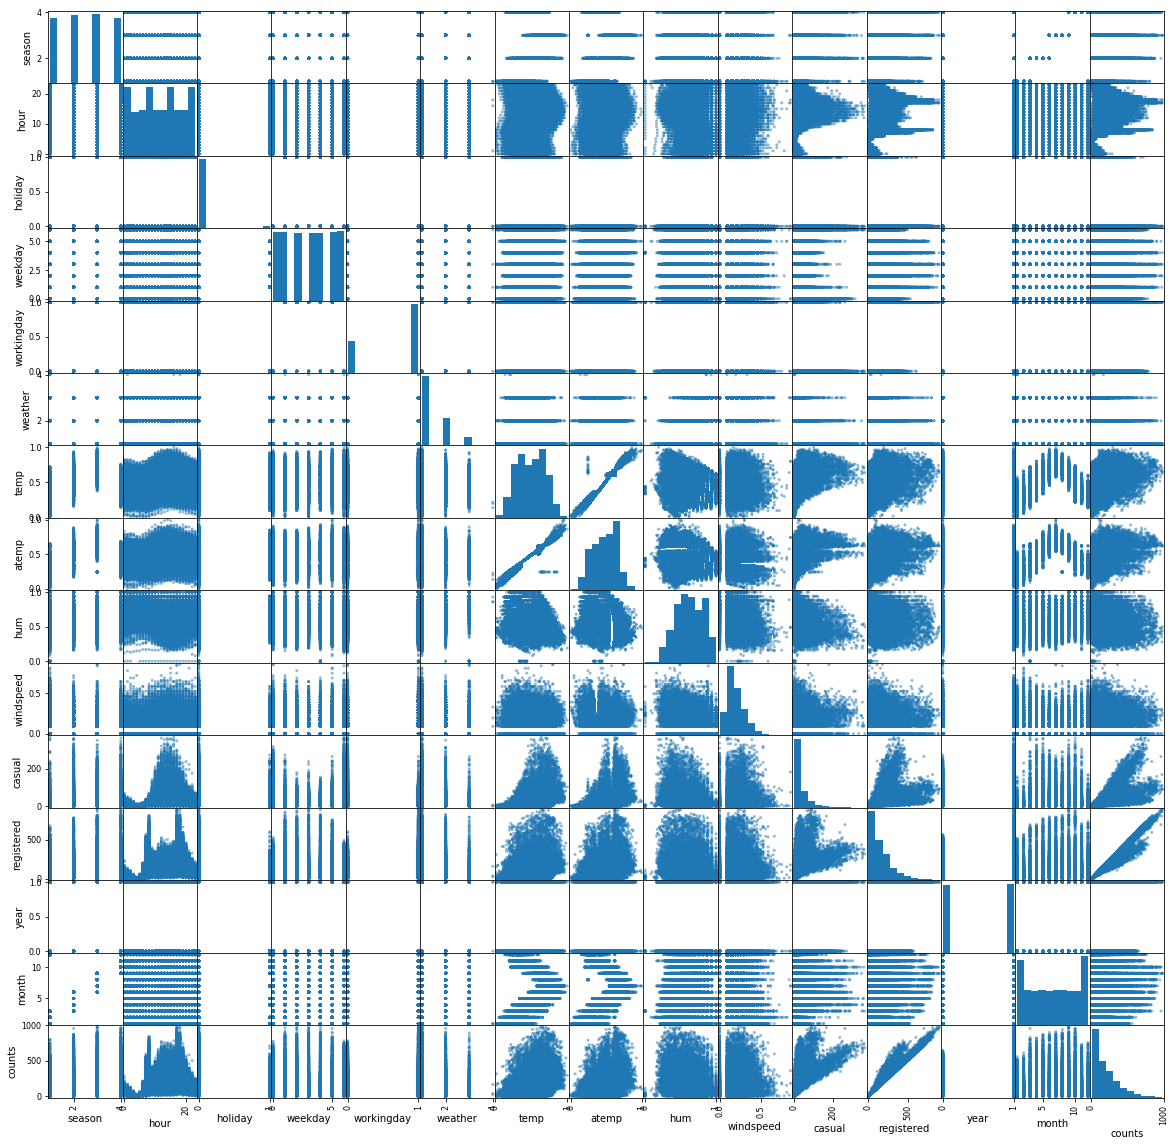

In [86]:
# your code here
fig = scatter_matrix(bikes_df, figsize=(20,20))

The strong relationships are: registered vs hour, casual vs hour, temp vs atemp, atemp vs temp, counts vs registered, registered vs counts, month vs temp (it looks weird because its an ordinal variable), month vs atemp. There might be a weak relationship between temp and hour, 

#### **2.2** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 

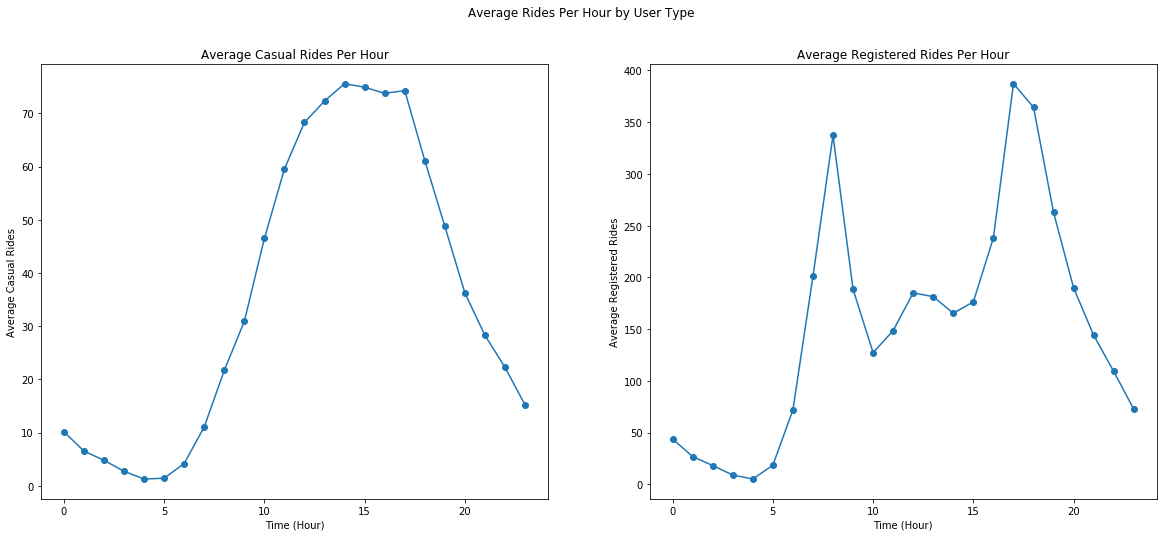

In [163]:
# your code here
fig, ax = plt.subplots(1,2, figsize=(20,8))
fig.suptitle("Average Rides Per Hour by User Type")
av_casualregistered_df = bikes_df.groupby(["hour"]).agg({
    "casual": np.mean,
    "registered": np.mean
})
ax[0].plot(av_casualregistered_df["casual"], "o-")
ax[0].set(xlabel="Time (Hour)", ylabel = "Average Casual Rides")
ax[0].set_title("Average Casual Rides Per Hour")
ax[1].plot(av_casualregistered_df["registered"], "o-")
ax[1].set(xlabel="Time (Hour)", ylabel = "Average Registered Rides")
ax[1].set_title("Average Registered Rides Per Hour")
plt.show()

We can intuit two trends from the visualization of this data. For Casual riders, we see that average rides peak between 1pm and 6pm and falls before and after those times. This makes sense - we would expect a Casual rider to "take an afternoon stroll" for enjoyment purposes and to use bikes less outside this window of time. For Registered riders, we observe two peak times, in the morning around 8am and in the evening 5pm, much less rides outside this interval, and a lull in rides during this interval. This also makes sense - we expect many Registered riders to be using this service to commute to and from work (in which the peak commute times are around 8am and 5pm) and less outside these times. Additionally, we see more usage for Registered riders overall, which makes sense because Registered riders are more consistent users of the platform.

#### **2.3** Use the variable `weather` to show how each weather category affects the relationships in question 2.2.  What do you observe?

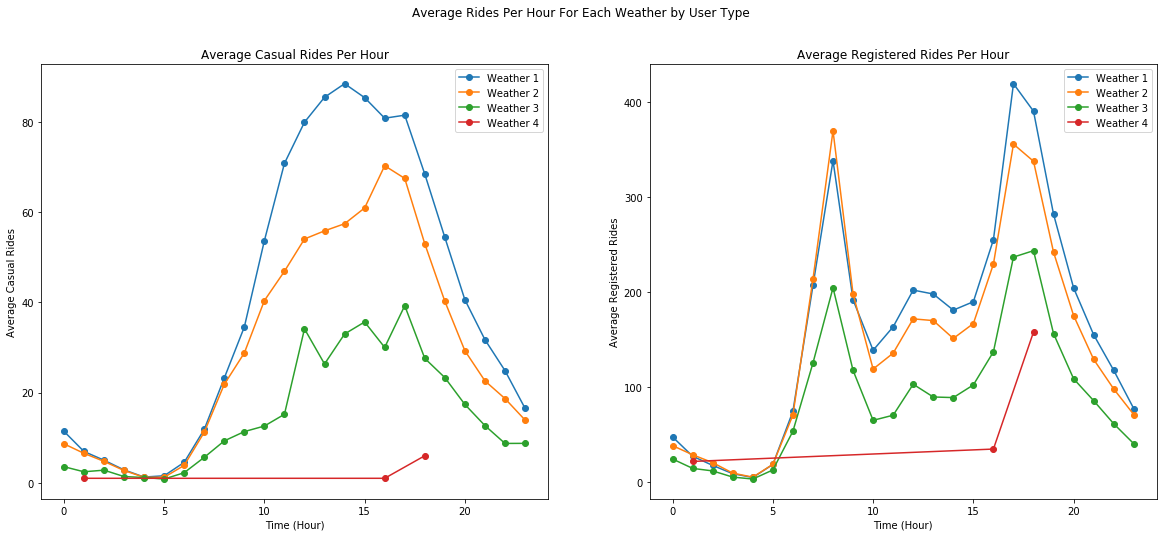

In [164]:
# your code here
fig, ax = plt.subplots(1,2, figsize=(20,8))
fig.suptitle("Average Rides Per Hour For Each Weather by User Type")
weather_hour_df = bikes_df.groupby(["weather","hour"]).agg({
    "casual": np.mean,
    "registered": np.mean
})
ax[0].plot(weather_hour_df["casual"][1], "o-", label="Weather 1")
ax[0].plot(weather_hour_df["casual"][2], "o-", label="Weather 2")
ax[0].plot(weather_hour_df["casual"][3], "o-", label="Weather 3")
ax[0].plot(weather_hour_df["casual"][4], "o-", label="Weather 4")
ax[0].set(xlabel="Time (Hour)", ylabel = "Average Casual Rides")
ax[0].set_title("Average Casual Rides Per Hour")
ax[0].legend()

ax[1].plot(weather_hour_df["registered"][1], "o-", label="Weather 1")
ax[1].plot(weather_hour_df["registered"][2], "o-", label="Weather 2")
ax[1].plot(weather_hour_df["registered"][3], "o-", label="Weather 3")
ax[1].plot(weather_hour_df["registered"][4], "o-", label="Weather 4")
ax[1].set(xlabel="Time (Hour)", ylabel = "Average Registered Rides")
ax[1].set_title("Average Registered Rides Per Hour")
ax[1].legend()
plt.show()

For casual riders, ridership declines steadily with progressively severe weather at all hours of the day, but interestingly weather affects registered riders differently. A shift from Weather 1 to Weather 2 has close to no effect on ridership. Weather 3 conditions does see a decline, but not as preciptously as for casual riders. This is likely because registered riders are commuters who need to travel to work every day rain or shine, and only start to find other methods of transportation when encountering conditions like snow (weather 3). For both casual and registered riders, however, the general trend of their relationships (as viewed and discussed in 2.2) remains the same (midday bump for casuals and rush hour spikes for registered) under weather conditions 1-3, just with varying magnitude. Weather 4 completely changes the relationship for both.

#### **2.4** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature (normalized)
- `atemp`, the average atemp that day (normalized)
- `windspeed`, the average windspeed that day (normalized)
- `hum`, the average humidity that day (normalized)
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

#### Name this dataframe `bikes_by_day`.

#### Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

In [175]:
# your code here
def get_daily_df(df):  
    return df.groupby(["dteday"]).agg({
        "dteday": np.min, #min or max choice arbitrary
        "weekday" : np.min, #min or max choice arbitrary
        "weather" : np.max,
        "season" : np.min,
        "temp" : np.mean,
        "atemp" : np.mean,
        "windspeed" : np.mean,
        "hum" : np.mean,
        "casual" : np.sum,
        "registered" : np.sum,
        "counts" : np.sum
    })

[Text(0,0.5,'Registered Rides'), Text(0.5,0,'Weekday')]

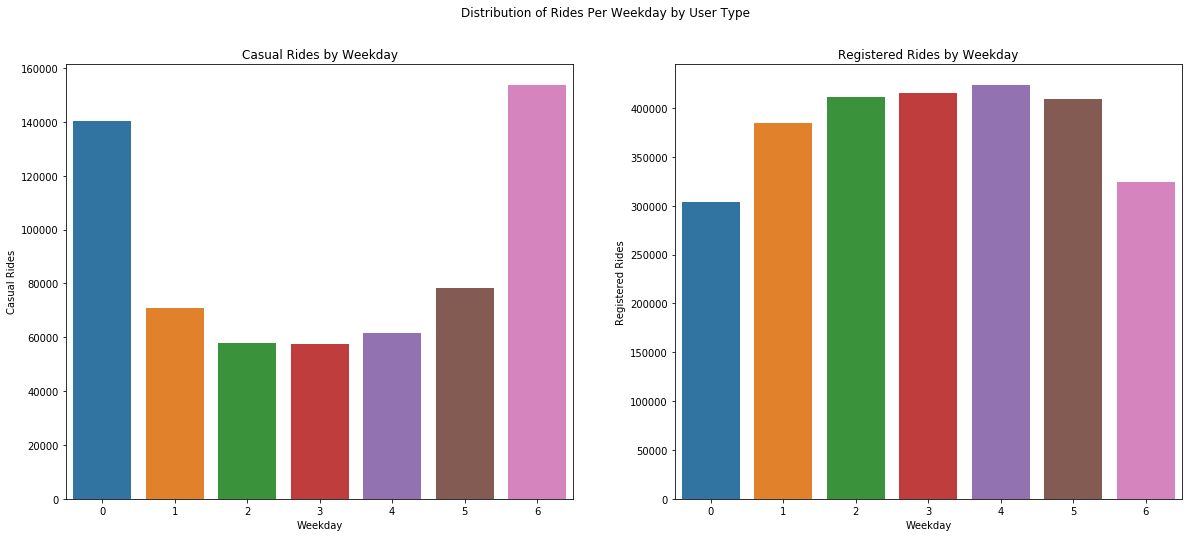

In [176]:
bikes_by_day = get_daily_df(bikes_df)
fig, ax = plt.subplots(1,2, figsize=(20,8))
fig.suptitle("Distribution of Rides Per Weekday by User Type")
dist_casualregistered_df = bikes_by_day.groupby(["weekday"]).agg({
    "weekday" : np.min,
    "casual": np.sum,
    "registered": np.sum
})
ax[0]= sns.barplot(x="weekday",y="casual",data=dist_casualregistered_df,ax=ax[0])
ax[0].set_title("Casual Rides by Weekday")
ax[0].set(xlabel="Weekday", ylabel = "Casual Rides")
ax[1] = sns.barplot(x="weekday",y="registered",data=dist_casualregistered_df,ax=ax[1])
ax[1].set_title("Registered Rides by Weekday")
ax[1].set(xlabel="Weekday", ylabel = "Registered Rides")

We can intuit trends from this visualization. As discussed before, there are more Registered rides overall (the least busy day for Registered users has more rides than the busiest day for Casual users) which makes sense because a Registered user should use the service more. As far as weekly trends go, we see that Casual riders use the platform most heavily on the weekends (day 0 and 6). This is consistent with our "take an afternoon stroll" analysis from the previous visualization. Casual users have more leisure time on the weekends versus during the week when they have work, so naturally they will take more bikerides on the weekend. For Registered users, we see a trend consistent with our commute hypothesis. Registered rides peak during workdays, Monday through Friday (day 1 through 5), and fall on the weekends.

#### **2.5** Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'dteday' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


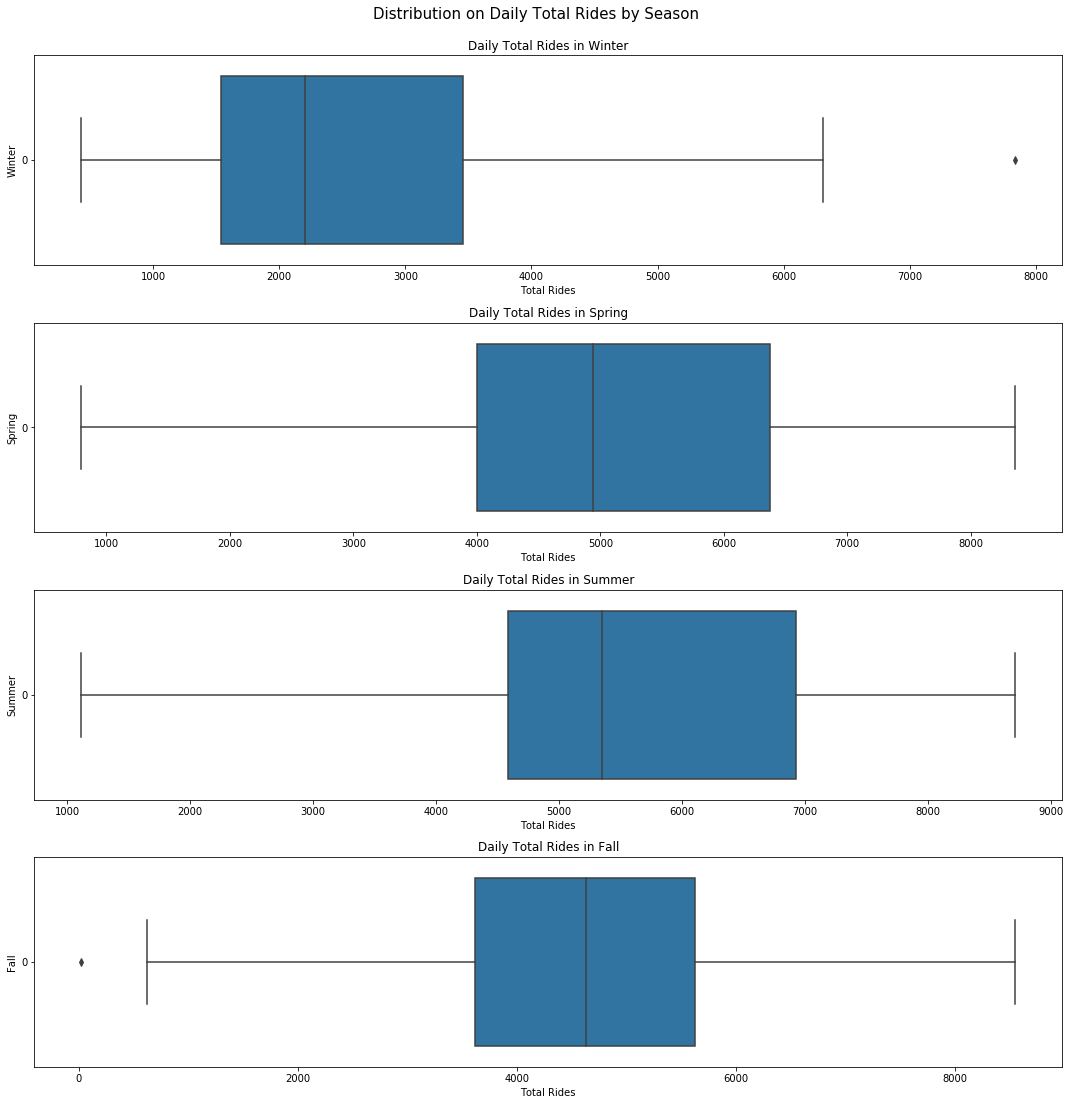

In [188]:
# your code here 
dist_seasonalcount_df = bikes_by_day.groupby(["season","dteday"]).agg({
    "counts" : np.sum
})
fig, ax = plt.subplots(4,1, figsize=(15,15))
fig.suptitle("Distribution on Daily Total Rides by Season", y=1.02, fontsize=15)
sns.boxplot(data=dist_seasonalcount_df["counts"][1],ax=ax[0], orient="h")
ax[0].set_title("Daily Total Rides in Winter")
ax[0].set(xlabel="Total Rides", ylabel="Winter")
sns.boxplot(data=dist_seasonalcount_df["counts"][2],ax=ax[1], orient="h")
ax[1].set_title("Daily Total Rides in Spring")
ax[1].set(xlabel="Total Rides", ylabel="Spring")
sns.boxplot(data=dist_seasonalcount_df["counts"][3],ax=ax[2], orient="h")
ax[2].set_title("Daily Total Rides in Summer")
ax[2].set(xlabel="Total Rides", ylabel="Summer")
sns.boxplot(data=dist_seasonalcount_df["counts"][4],ax=ax[3], orient="h")
ax[3].set_title("Daily Total Rides in Fall")
ax[3].set(xlabel="Total Rides", ylabel="Fall")
fig.tight_layout()

In [204]:
# your code here
dist_seasonalcount_df.loc[dist_seasonalcount_df["counts"]>7000].head(1)

,,counts
season,dteday,
1,2012-03-17,7836


In [222]:
# your code here
dist_seasonalcount_df.loc[dist_seasonalcount_df["counts"]<500].head()

counts
season dteday            
1      2011-01-27     431
       2012-12-26     441
4      2012-10-29      22

We found two outliers. The first is in the winter on Saint Patricks Day 2012-03-17. This day was extremely warm for the winter, and it also being a holiday led to many people using the bikeshare platform. The second occurred on 2012-10-29 during the Fall. Businesses were closed this day due to Hurricane Sandy so naturally very few people needed to use the bikeshare platform.

<div class='exercise'> <b> Question 3: Prepare the data for Regression </b> </div>

In order to build and evaluate our regression models, a little data cleaning is needed.  In this problem, we will explicitly create binary variables to represent the categorical predictors, set up the train-test split in a careful way, remove ancillary variables, and do a little data exploration that will be useful to consider in the regression models later.

**3.1** Using `bikes_df`, with hourly data about rentals, convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding**.

**3.2** Split the updated `bikes_df` dataset in a train and test part. Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set. Explain your choice for a splitting algorithm. 

**3.3** Although we asked you to create your train and test set, but for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the he files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). Also, remove any predictors that would make predicting the `count` trivial. Note we gave more meaningful names to the one-hot encoded variables.



#### Answers

#### **3.1** Using `bikes_df`, with hourly data about rentals, convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding**.

In [91]:
# your code here
months = bikes_df["month"]
bikes_df = pd.get_dummies(bikes_df, columns=['season','month','weekday'], drop_first=True)

####  **3.2** Split the updated `bikes_df` dataset in a train and test part. Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set. Explain your choice for a splitting algorithm.

In [223]:
bikes_df["month"] = months
train_data, test_data = train_test_split(bikes_df, test_size = 1000, 
                                             stratify=bikes_df['month'])

We used the standard sklearn train_test_split method, which we have used in the past. It has a 'stratify' argument which allows us to split our data in a properly stratified way amongst several variables. We stratified on month as the question specified. For the size of the test set, we decided upon an absolute value of 1000. The whole dataset is large (over 17000), so we decided that a hard value would be better than a percentage. As we discussed in lecture, with larger datasets, we dont want to take too much out from the training data and miss some trends. We may also want to stratify on weekday as well, as there are significant differences between the activity accross, but the question does not ask for this, so we do not.

#### **3.3** Although we asked you to create your train and test set, but for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the he files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). Also, remove any predictors that would make predicting the `count` trivial. Note we gave more meaningful names to the one-hot encoded variables.

In [238]:
BSS_train = pd.read_csv("data/BSS_train.csv")
BSS_test = pd.read_csv("data/BSS_test.csv")

BSS_train = BSS_train.drop(columns=["dteday","casual","registered"])
BSS_test = BSS_test.drop(columns=["dteday","casual","registered"])

We additionally eliminated the casual and registered columns as these datapoints make calculating the total count trivial since it is just the sum of casual and registered.

<div class='exercise'> <b> Question 4: Multiple Linear Regression </b> </div>

**4.1** Use statsmodels to fit a multiple linear regression model to the training set using all the predictors (no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.

**4.2** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). You should see some strange values, such as `July` producing 93 fewer rentals, all else equal, than January.

**4.3** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

**4.4** Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from `X_train` with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

**4.5** The strange coefficients from 4.2 could also come from _multicolinearity_, where one or more predictors capture the same information as existing predictors. Why can multicolinearity lead to erroneous coefficient values? Create a temporary dataset `X_train_drop` that drops the following 'redundant' predictors from `X_train`:  `workingday` `atemp` `spring` `summer` and `fall`. Fit a multiple linear regression model to `X_train_drop`. Are the estimates more sensible in this model?


### Answers
#### **4.1** Use statsmodels to fit a multiple linear regression model to the training set using all the predictors (no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.

In [243]:
# your code here
y_train = BSS_train["counts"]
y_test = BSS_test["counts"]

X_train = sm.add_constant(BSS_train.drop(columns=["counts"]))
X_test = sm.add_constant(BSS_test.drop(columns=["counts"]))

model = OLS(y_train, X_train).fit()

In [246]:
# your code here
print("The R-Squared on the train data is:") 
print(r2_score(y_train, model.predict(X_train)))

print("The R-Squared on the test data is:") 
print(r2_score(y_test, model.predict(X_test)))

The R-Squared on the train data is:
0.4065796113929744
The R-Squared on the test data is:
0.4064888895933878


#### **4.2** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). You should see some strange values, such as `July` producing 93 fewer rentals, all else equal, than January.

In [307]:
ps = pd.DataFrame(model.params)
p_coef = np.column_stack((model.pvalues,model.params,ps.index))
p_coef_sig = [[p[2],p[1]] for p in p_coef if p[0] < 0.05]
p_coef_sig = p_coef_sig[1:] #drop constant

In [313]:
print("The variables with statistically significant coefficients and their respective coefficients are:")
p_coef_sig

The variables with statistically significant coefficients and their respective coefficients are:


[['hour', 7.225333972001318],
 ['holiday', -18.20585034693519],
 ['year', 124.51439853682945],
 ['workingday', 11.354591299016342],
 ['temp', 335.4971134701142],
 ['hum', -205.2434414625413],
 ['windspeed', 22.591386827651448],
 ['spring', 43.264079705764544],
 ['summer', 29.64368949165677],
 ['fall', 68.41762620224624],
 ['Jun', -46.3921239132135],
 ['Jul', -70.07462310490097],
 ['Sat', 14.983420258017341],
 ['Cloudy', 6.755104724830521],
 ['Snow', -28.3475785133476]]

#### **4.3** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Residual Size')

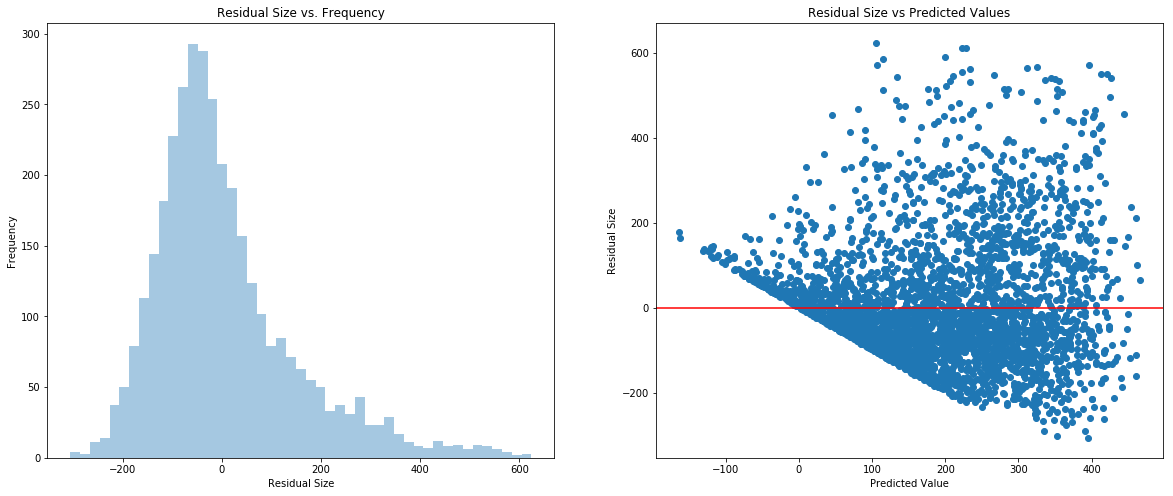

In [342]:
# your code here
fig, ax = plt.subplots(1,2,figsize=(20,8))
y_pred = model.predict(X_test)
resids = y_test - y_pred
sns.distplot(resids, kde=False, ax=ax[0])
ax[0].set_title("Residual Size vs. Frequency")
ax[0].set_xlabel("Residual Size")
ax[0].set_ylabel("Frequency")

ax[1].scatter(y_pred,resids)
ax[1].axhline(y=0,color="r", linestyle="-")
ax[1].set_title("Residual Size vs Predicted Values")
ax[1].set_xlabel("Predicted Value")
ax[1].set_ylabel("Residual Size")

*your answer here* 

#### **4.4** Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from `X_train` with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

In [410]:
# your code here
X_train_poly = X_train
X_train_poly["temp2"] = X_train["temp"]**2
X_train_poly["hour2"] = X_train["hour"]**2
X_train_poly["hum2"] = X_train["hum"]**2
X_train_poly = X_train_poly.drop(["const", "Unnamed: 0"], axis=1)

#X_test_poly = X_test
#X_test_poly["temp2"] = X_test["temp"]**2
#X_test_poly["hour2"] = X_test["hour"]**2
#X_test_poly["hum2"] = X_test["hum"]**2

In [357]:
poly_model = OLS(y_train, X_train_poly).fit()
poly_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     365.2
Date:                Tue, 02 Oct 2018   Prob (F-statistic):               0.00
Time:                        23:38:31   Log-Likelihood:                -87488.
No. Observations:               13903   AIC:                         1.750e+05
Df Residuals:                   13868   BIC:                         1.753e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.4107      9.322     -1.117      0.264     -28.683       7.862
Unnamed: 0    -0.0045      0.005     -0.843      0.399      -0.015       0.006
hour           0.0030   5.12e-05     57.778      0.000       0.003       0.003
holiday      -15.8598      6.228     -2.547      0.011     -28.067      -3.653
year         119.1393     46.545      2.560      0.010      27.904     210.374
workingday    11.8973      2.595      4.584      0.000       6.810      16.984
temp           1.6310     59.909      0.027      0.978    -115.798     119.060
atemp        115.3934     44.917      2.569      0.010      27.349     203.437
hum         -122.5234     20.913     -5.859      0.000    -163.516     -81.531
windspeed      5.0983     10.191      0.500      0.617     -14.877      25.074
spring        40.6630      6.998      5.811      0.000      26.946      54.380
summer        30.8442      8.294      3.719      0.000      14.588      47.101
fall          70.9791      7.077     10.029      0.000      57.106      84.852
Feb            8.7142      6.781      1.285      0.199      -4.577      22.005
Mar           19.4143      9.797      1.982      0.048       0.211      38.618
Apr            3.4517     14.610      0.236      0.813     -25.185      32.089
May           15.3665     18.014      0.853      0.394     -19.942      50.676
Jun           -6.9523     21.341     -0.326      0.745     -48.784      34.879
Jul          -37.6367     25.336     -1.486      0.137     -87.299      12.025
Aug            0.6521     28.841      0.023      0.982     -55.881      57.185
Sept          41.1781     32.206      1.279      0.201     -21.950     104.307
Oct           37.3783     35.959      1.039      0.299     -33.106     107.863
Nov           21.2157     39.654      0.535      0.593     -56.512      98.944
Dec           33.7218     42.993      0.784      0.433     -50.551     117.994
Mon           -3.0176      2.808     -1.074      0.283      -8.522       2.487
Tue           -5.3261      3.025     -1.760      0.078     -11.256       0.604
Wed            2.1184      3.002      0.706      0.480      -3.766       8.003
Thu           -1.2833      3.004     -0.427      0.669      -7.172       4.605
Fri            3.5488      3.005      1.181      0.238      -2.341       9.439
Sat           13.9774      4.133      3.382      0.001       5.875      22.080
Cloudy         3.5459      2.740      1.294      0.196      -1.826       8.918
Snow         -39.3504      4.699     -8.374      0.000     -48.561     -30.140
Storm        -16.7091     92.800     -0.180      0.857    -198.609     165.191
temp2        217.6178     37.415      5.816      0.000     144.279     290.957
hour2      -1.186e-08   2.08e-10    -57.081      0.000   -1.23e-08   -1.15e-08
hum2           5.3608     20.621      0.260      0.795     -35.059      45.780
==

*your answer here*


#### **4.5** The strange coefficients from 4.2 could also come from _multicolinearity_, where one or more predictors capture the same information as existing predictors. Why can multicolinearity lead to erroneous coefficient values? Create a temporary dataset `X_train_drop` that drops the following 'redundant' predictors from `X_train`:  `workingday` `atemp` `spring` `summer` and `fall`. Fit a multiple linear regression model to `X_train_drop`. Are the estimates more sensible in this model?

In [398]:
# your code here
X_train_drop = X_train.drop(['workingday', 'atemp', 'spring', 'summer', 'fall'], axis=1)
X_test_drop = X_test.drop(['workingday', 'atemp', 'spring', 'summer', 'fall'], axis=1)
drop_model = OLS(y_train,X_train_drop).fit()
drop_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     405.7
Date:                Wed, 03 Oct 2018   Prob (F-statistic):               0.00
Time:                        14:48:08   Log-Likelihood:                -87554.
No. Observations:               13903   AIC:                         1.752e+05
Df Residuals:                   13872   BIC:                         1.754e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.7353      9.355     -1.254      0.210     -30.073       6.602
Unnamed: 0    -0.0064      0.005     -1.200      0.230      -0.017       0.004
hour           0.0030   5.14e-05     57.671      0.000       0.003       0.003
holiday      -34.3888      6.990     -4.920      0.000     -48.089     -20.688
year         135.5979     46.688      2.904      0.004      44.082     227.114
temp         150.3997     37.661      3.993      0.000      76.578     224.221
hum         -121.6034     20.622     -5.897      0.000    -162.024     -81.182
windspeed     -8.3743      9.885     -0.847      0.397     -27.750      11.001
Feb            9.1384      6.809      1.342      0.180      -4.207      22.484
Mar           34.0144      9.566      3.556      0.000      15.264      52.764
Apr           45.5181     13.015      3.497      0.000      20.007      71.029
May           56.9976     16.814      3.390      0.001      24.041      89.954
Jun           32.4947     20.545      1.582      0.114      -7.776      72.766
Jul           -2.4271     24.369     -0.100      0.921     -50.194      45.340
Aug           35.1852     28.008      1.256      0.209     -19.714      90.084
Sept          88.4971     31.635      2.797      0.005      26.489     150.506
Oct          116.9930     35.279      3.316      0.001      47.842     186.144
Nov          104.0029     39.007      2.666      0.008      27.544     180.461
Dec           93.8312     42.780      2.193      0.028       9.976     177.686
Mon            9.5054      4.313      2.204      0.028       1.051      17.960
Tue            6.1905      4.192      1.477      0.140      -2.027      14.408
Wed           13.4979      4.168      3.238      0.001       5.327      21.669
Thu           10.4251      4.195      2.485      0.013       2.203      18.647
Fri           14.0502      4.179      3.362      0.001       5.858      22.243
Sat           13.1250      4.151      3.162      0.002       4.989      21.261
Cloudy         3.3186      2.751      1.206      0.228      -2.075       8.712
Snow         -40.5661      4.719     -8.597      0.000     -49.815     -31.317
Storm        -17.9772     93.226     -0.193      0.847    -200.714     164.759
temp2        177.9056     36.905      4.821      0.000     105.568     250.243
hour2      -1.188e-08   2.09e-10    -56.976      0.000   -1.23e-08   -1.15e-08
hum2           6.5770     20.294      0.324      0.746     -33.202      46.356
==============================================================================
Omnibus:                     3092.716   Durbin-Watson:                   0.826
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6706.251
Skew:                           1.288   Prob(JB):                         0.00
Kurtosis:                       5.222   Cond. No.                     1.98e+12
==

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Residual Size')

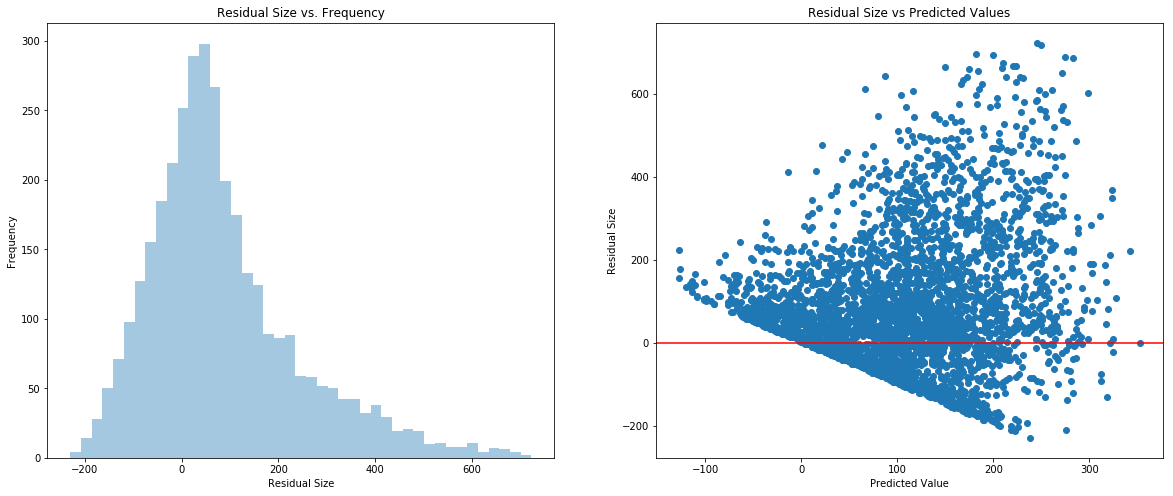

In [397]:
fig, ax = plt.subplots(1,2,figsize=(20,8))
y_pred = drop_model.predict(X_test_drop)
resids = y_test - y_pred
sns.distplot(resids, kde=False, ax=ax[0])
ax[0].set_title("Residual Size vs. Frequency")
ax[0].set_xlabel("Residual Size")
ax[0].set_ylabel("Frequency")

ax[1].scatter(y_pred,resids)
ax[1].axhline(y=0,color="r", linestyle="-")
ax[1].set_title("Residual Size vs Predicted Values")
ax[1].set_xlabel("Predicted Value")
ax[1].set_ylabel("Residual Size")

*your answer here*


<div class='exercise'><b> Question 5: Subset Selection </b> </div>
Perhaps we can automate finding a good set of predictors. This question focuses on forward stepwise selection, where predictors are added to the model one by one.

**5.1** Implement forward step-wise selection to select a minimal subset of predictors that are related to the response variable. Run your code on the richest dataset, `X_train_poly`, and determine which predictors are selected.

We require that you implement the method **from scratch**. You may use the Bayesian Information Criterion (BIC) to choose the best subset size. 

<i>Note: Implementing from scratch means you are not allowed to use a solution provided by a Python library, such as sklearn or use a solution you found on the internet. You have to write all of the code on your own. However you MAY use the `model.bic` attribute implemented in statsmodels.</i>

**5.2** Does forward selection eliminate one or more of the colinear predictors we dropped in Question  4.5 (`workingday` `atemp` `spring` `summer` and `fall`)? If any of the five predictors are not dropped, explain why.

**5.3** Fit the linear regression model using the identified subset of predictors to the training set. How do the train and test $R^2$ scores for this fitted step-wise model compare with the train and test $R^2$ scores from the polynomial model fitted in Question 4.4?

### Answers

#### **5.1** Implement forward step-wise selection to select a minimal subset of predictors that are related to the response variable. Run your code on the richest dataset, `X_train_poly`, and determine which predictors are selected.

#### We require that you implement the method **from scratch**. You may use the Bayesian Information Criterion (BIC) to choose the best subset size. 

#### <i>Note: Implementing from scratch means you are not allowed to use a solution provided by a Python library, such as sklearn or use a solution you found on the internet. You have to write all of the code on your own. However you MAY use the `model.bic` attribute implemented in statsmodels.</i>

In [417]:
# your code here
def get_best_predictors(X_train, y_train):
    best_bic=np.inf
    predictors = X_train.columns
    best_predictors = []
    
    for i in range(len(predictors)):
        best_new_pred = None
        for pred in predictors: 
            new_preds = best_predictors
            new_preds.append(pred)
            X_pred = sm.add_constant(X_train[new_preds])
            model = OLS(y_train,X_pred).fit()
            print (pred)
            print (new_preds)
            print (model.bic)
            print ("best bic: "+str(best_bic))
            print ("best_new_pred: "+ str(best_new_pred))
            if model.bic < best_bic:
                best_bic = model.bic
                best_new_pred = pred

        if best_new_pred != None:
            best_predictors.append(best_new_pred)
        else:
            break
    return best_predictors

In [418]:
# your code here
get_best_predictors(X_train_poly,y_train)

hour
['hour']
183690.50588306575
best bic: inf
best_new_pred: None
holiday
['hour', 'holiday']
183688.1578148352
best bic: 183690.50588306575
best_new_pred: hour
year
['hour', 'holiday', 'year']
182822.37225276016
best bic: 183688.1578148352
best_new_pred: holiday
workingday
['hour', 'holiday', 'year', 'workingday']
182824.71712228082
best bic: 182822.37225276016
best_new_pred: year
temp
['hour', 'holiday', 'year', 'workingday', 'temp']
180337.16555803447
best bic: 182822.37225276016
best_new_pred: year
atemp
['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp']
180346.7045468594
best bic: 180337.16555803447
best_new_pred: temp
hum
['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum']
178939.42209416602
best bic: 180337.16555803447
best_new_pred: temp
windspeed
['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum', 'windspeed']
178927.99678060986
best bic: 178939.42209416602
best_new_pred: hum
spring
['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp',

temp
['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm', 'temp2', 'hour2', 'hum2', 'hour2', 'hour', 'holiday', 'year', 'workingday', 'temp']
175302.05072140653
best bic: 175292.58533488814
best_new_pred: None
atemp
['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm', 'temp2', 'hour2', 'hum2', 'hour2', 'hour', 'holiday', 'year', 'workingday', 'temp', 'atemp']
175302.05072140932
best bic: 175292.58533488814
best_new_pred: None
hum
['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 

Thu
['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm', 'temp2', 'hour2', 'hum2', 'hour2', 'hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu']
175302.05072147207
best bic: 175292.58533488814
best_new_pred: None
Fri
['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm', 'temp2', 'hour2', 'hum2', 'hour2', 'hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr', 'May', 

['hour',
 'holiday',
 'year',
 'workingday',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'spring',
 'summer',
 'fall',
 'Feb',
 'Mar',
 'Apr',
 'May',
 'Jun',
 'Jul',
 'Aug',
 'Sept',
 'Oct',
 'Nov',
 'Dec',
 'Mon',
 'Tue',
 'Wed',
 'Thu',
 'Fri',
 'Sat',
 'Cloudy',
 'Snow',
 'Storm',
 'temp2',
 'hour2',
 'hum2',
 'hour2',
 'hour',
 'holiday',
 'year',
 'workingday',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'spring',
 'summer',
 'fall',
 'Feb',
 'Mar',
 'Apr',
 'May',
 'Jun',
 'Jul',
 'Aug',
 'Sept',
 'Oct',
 'Nov',
 'Dec',
 'Mon',
 'Tue',
 'Wed',
 'Thu',
 'Fri',
 'Sat',
 'Cloudy',
 'Snow',
 'Storm',
 'temp2',
 'hour2',
 'hum2']

In [395]:
set(subsets_predictors)
#set(subsets_predictors)^set(["hour"])

set()

#### **5.2** Does forward selection eliminate one or more of the colinear predictors we dropped in Question  4.5 (`workingday` `atemp` `spring` `summer` and `fall`)? If any of the five predictors are not dropped, explain why.

*your answer here*


#### **5.3** Fit the linear regression model using the identified subset of predictors to the training set. How do the train and test $R^2$ scores for this fitted step-wise model compare with the train and test $R^2$ scores from the polynomial model fitted in Question 4.4?

In [42]:
# your code here


*your answer here*


#  Written Report to the Administrators [20 pts]
<br>

<div class='exercise'> <b> Question 6 </b> </div>

Write a short repost stating some of your findings on how the administrators can increase the bike share system's revenue. You might want to include suggestions such as what model to use to predict ridership, what additional services to provide, or when to give discounts, etc. 
Include your report as a pdf file in canvas. The report should not be longer than one page (300 words) and should include a maximum of 5 figures. 

#### Answers 6




*your answer here*


In [43]:
# your code here


*your answer here* 


In [44]:
#your code here


*your answer here* 
